# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, roc_auc_score, precision_score, recall_score 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt

In [2]:
# откроем сначала всю выборку, чтобы удалить абсолютно ненужные переменные:
X = pd.read_csv('orange_small_churn_data.txt', header = 0, sep = ',')
y = np.fromfile('orange_small_churn_labels.txt', dtype=int, sep='\n') 
print(X.shape, y.shape)

(40000, 230) (40000,)


Удалим переменные, изначально полностью пустые, а также некоторые повторяющиеся (числовых: 16 из 190 , категориальных: 5 из 40).  
Следующие категориальные переменные имеют одинаковое кол-во пропущенных значений и однаковые корреляции с целевой переменной:
* Var198, Var220, Var222, 
* Var200, Var214,     

поэтому оставим 'Var198' и 'Var200', к примеру.

In [3]:
X.drop(['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52',
        'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 
        'Var209', 'Var230', 'Var220', 'Var222', 'Var214'], 1, inplace=True)

Разделим выборку сначала на обучение и контроль, а затем кросс-валидация сама разобьет X_train и y_train на обучение и валидацию:

In [4]:
X_train, X_control, y_train, y_control = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print (X_train.shape, X_control.shape)

(32000, 209) (8000, 209)


Стратегия кросс-валидации:

In [5]:
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 123)

Начальный пайплайн:

In [6]:
num_cols = X_train.iloc[:, :174]
cat_cols = X_train.iloc[:, 174:]

In [88]:
numeric_features = num_cols.columns.values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # заменим, к примеру, пропущенные значения на средние
    ('scaler', StandardScaler())]) # при дальнейшей кросс-валидации очень важно мастабировать признаки в пайплайне

categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')), 
    ('reduce_dim', TruncatedSVD(n_components=35, random_state=0))]) # поскольку общее кол-во категорий доходит до 42433, 
      # TruncatedSVD может очень хорошо подойти для снижения размерности разреженных матриц, 
      # к примеру, снизим кол-во компонент до первоначальных 35-и

preprocessor = ColumnTransformer(# чтобы применить трансформеры для каждого типа переменных по отдельности, а затем сцепить
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Будем оценивать только по average_precision и roc_auc, поскольку порог бинаризации будем подбирать после, в зависимости от экономических соображений:

In [7]:
scoring = {'prc_auc': 'average_precision', 'roc_auc': 'roc_auc'}

Функция для оценки модели:

In [8]:
def clf_pipe_results(name, clf, X_train, y_train):
    
    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 123)
    scoring = {'prc_auc': 'average_precision',
               'roc_auc': 'roc_auc'}
    basic_scoring = cross_validate(clf, X_train, y_train, cv = skf, scoring = scoring)
    results = pd.DataFrame(columns=['prc_auc', 'roc_auc'], index=[name])
    results['prc_auc'] = basic_scoring['test_prc_auc'].mean()
    results['roc_auc'] = basic_scoring['test_roc_auc'].mean()
    
    return results

## Undersampling

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [128]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(random_state=2))])

In [93]:
train_sizes, train_scores, test_scores = learning_curve(clf_xgb, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10),
                                                                       cv=skf, scoring='prc_auc', n_jobs=-1)

In [95]:
print (train_sizes)
print (train_scores.mean(axis = 1))
print (test_scores.mean(axis = 1))

[ 2399  4799  7199  9599 11999 14399 16799 19199 21599 23999]
[0.98452026 0.94075713 0.90288325 0.87253647 0.85581247 0.84193111
 0.8320785  0.82104343 0.81285296 0.80681977]
[0.66738749 0.68954775 0.7026063  0.71265075 0.71593997 0.71888171
 0.72321013 0.72538693 0.72846089 0.72656079]


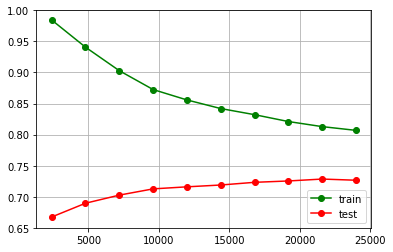

In [97]:
plt.grid(True)
plt.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
plt.ylim((0.65, 1.0))
plt.legend(loc='lower right')

#### Кривая обучения продолжает уменьшаться при при росте кол-ва объектов, однако тестовая кривая значительно растет до 10000 и затем слабо продолжает расти до 21599 объекта. Можно сделать вывод, что для построения качественной модели достаточно 10-15 тыс. объектов обучающей выборки.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [134]:
print (len(y_train[y_train==1])/len(y_train))
print (len(y_train[y_train==-1])/len(y_train))

0.07440625
0.92559375


При xgbclassifier кривая оценок ровная, поэтому построим кривую для randomforestclassifier изменяя class_weight в классификаторе:

In [ ]:
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=200, max_depth=8, random_state=1))])
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=clf_rf,
    param_grid={
        'classifier__class_weight': [{-1: x, 1: 1.0-x} for x in weights]
    },
    refit='prc_auc',
    scoring=scoring,
    cv=skf
)
grid_result = gsc.fit(X_train, y_train)

Best parameters : {'classifier__class_weight': {-1: 0.28684210526315784, 1: 0.7131578947368422}}


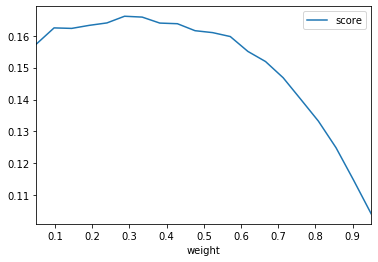

In [131]:
print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs prc_auc score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_prc_auc'],
                       'weight': weights })
dataz.plot(x='weight')

#### При изменении весов классов результаты классификации модели изменяются, лучший результат достигается при весе класса 1 в 0.7131, оптимальным вариантом будет вес класса в 0.5, поскольку при увеличени веса класса 1 от 0.7131 к 1, результаты не увеличиваются.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [189]:
# данный пайплайн позволит использовать fit_sample в общем пайплайне, по сравнению с sklearn.pipeline.Pipeline
from imblearn.pipeline import Pipeline

#### RandomUnderSampler

In [68]:
from imblearn.under_sampling import RandomUnderSampler
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', RandomUnderSampler(random_state=2)),
                          ('classifier', XGBClassifier(random_state=2))])

In [69]:
clf_pipe_results('xgboost_rus', clf_xgb, X_train, y_train)

,prc_auc,roc_auc
xgboost_rus,0.176577,0.719175


#### TomekLinks

In [60]:
from imblearn.under_sampling import TomekLinks
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', TomekLinks(random_state=2)),
                          ('classifier', XGBClassifier(random_state=2))])

In [61]:
clf_pipe_results('xgboost_tl', clf_xgb, X_train, y_train)

,prc_auc,roc_auc
xgboost_tl,0.189859,0.726386


#### NeighbourhoodCleaningRule

In [70]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', NeighbourhoodCleaningRule(random_state=2)),
                          ('classifier', XGBClassifier(random_state=2))])

In [71]:
clf_pipe_results('xgboost_ncc', clf_xgb, X_train, y_train)

,prc_auc,roc_auc
xgboost_ncc,0.19221,0.726136


#### EditedNearestNeighbours

In [76]:
from imblearn.under_sampling import EditedNearestNeighbours
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', EditedNearestNeighbours(random_state=2)),
                          ('classifier', XGBClassifier(random_state=2))])

In [77]:
clf_pipe_results('xgboost_enn', clf_xgb, X_train, y_train)

,prc_auc,roc_auc
xgboost_enn,0.188334,0.724279


#### Качество модели как и результаты классификации при разных стратегиях undersampling меняются, последние три стратегии оказались близкими по методу удаления объектов. RandomUnderSampler оказалась самый быстрой, однако она оставляет равное кол-во объектов неоттока и оттока, т.е. меньше чем 5000. TomekLinks оказалась самой долгой. Наиболее оптимальной с точки зрения качества оказалась стратегия NeighbourhoodCleaningRule.

## Обработка пропущенных значений

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

В данном случае будем рассматривать только числовые перменные, поскольку в категориальных переменных, обработка пропущенных значений будет выглядеть как просто добавление еще одной категории: 

In [140]:
clf_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__encoder', 'preprocessor__cat__reduce_dim', 'preprocessor__cat__im

Рассмотрим обработку пропущенных значений числовых перменных путем замены нулем, средней и медианой:

In [141]:
parameters_grid_xgb = {'preprocessor__num__imputer__strategy':['constant','mean','median']}

In [142]:
grid_cv_xgb = GridSearchCV(clf_xgb, parameters_grid_xgb, refit='prc_auc', scoring = scoring, cv = skf, n_jobs=-1)

In [143]:
%%time
grid_cv_xgb.fit(X_train, y_train)

Wall time: 2min 28s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [145]:
print (grid_cv_xgb.best_score_)
print (grid_cv_xgb.best_params_)
print (grid_cv_xgb.best_index_)

0.19085622084313913
{'preprocessor__num__imputer__strategy': 'mean'}
1


In [146]:
grid_cv_xgb.cv_results_

{'mean_fit_time': array([33.08889258, 33.39340997, 33.87868774]),
 'std_fit_time': array([0.41301089, 0.71221645, 0.669896  ]),
 'mean_score_time': array([1.04305959, 1.02755886, 0.8685497 ]),
 'std_score_time': array([0.08257885, 0.06605108, 0.02460328]),
 'param_preprocessor__num__imputer__strategy': masked_array(data=['constant', 'mean', 'median'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'preprocessor__num__imputer__strategy': 'constant'},
  {'preprocessor__num__imputer__strategy': 'mean'},
  {'preprocessor__num__imputer__strategy': 'median'}],
 'split0_test_prc_auc': array([0.19782479, 0.19926788, 0.20228034]),
 'split1_test_prc_auc': array([0.18104612, 0.18408572, 0.17485186]),
 'split2_test_prc_auc': array([0.17893146, 0.17940426, 0.17766693]),
 'split3_test_prc_auc': array([0.20422084, 0.2006672 , 0.19225848]),
 'mean_test_prc_auc': array([0.1905056 , 0.19085622, 0.18676472]),
 'std_test_prc_auc': array([0.010783

In [148]:
print ("mean_test_prc_auc:", grid_cv_xgb.cv_results_['mean_test_prc_auc'])
print ("mean_test_roc_auc:", grid_cv_xgb.cv_results_['mean_test_roc_auc'])

mean_test_prc_auc: [0.1905056  0.19085622 0.18676472]
mean_test_roc_auc: [0.72353746 0.72677804 0.71760768]


#### Обработка пропущенных значений не сильно сказывается на результатах модели. Наиболее оптимальным с точки зрения качества оказалась обработка пропущенных значений путем замены средней.

## Обработка категориальных признаков

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [182]:
numeric_features = num_cols.columns.values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

#### OrdinalEncoder

In [184]:
from category_encoders import OrdinalEncoder
categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OrdinalEncoder(handle_unknown='ignore'))])
   
preprocessor_oe = ColumnTransformer(# чтобы применить трансформеры для каждого типа переменных по отдельности, а затем сцепить
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [185]:
clf_xgb_oe = Pipeline(steps=[('preprocessor', preprocessor_oe),
                      ('classifier', XGBClassifier(random_state=2))])

clf_pipe_results('xgboost_oe', clf_xgb_oe, X_train, y_train)

,prc_auc,roc_auc
xgboost_oe,0.185176,0.717738


#### HashingEncoder

In [186]:
from category_encoders import HashingEncoder
categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', HashingEncoder(n_components=35))]) # снизим кол-во компонент до первоначальных 35-и 

preprocessor_he = ColumnTransformer(# чтобы применить трансформеры для каждого типа переменных по отдельности, а затем сцепить
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [187]:
clf_xgb_he = Pipeline(steps=[('preprocessor', preprocessor_he),
                      ('classifier', XGBClassifier(random_state=2))])

clf_pipe_results('xgboost_he', clf_xgb_he, X_train, y_train)

,prc_auc,roc_auc
xgboost_he,0.196666,0.729535


#### BinaryEncoder

In [188]:
from category_encoders import BinaryEncoder
categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', BinaryEncoder())]) # получится 214 колонок
   
preprocessor_be = ColumnTransformer(# чтобы применить трансформеры для каждого типа переменных по отдельности, а затем сцепить
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [189]:
clf_xgb_be = Pipeline(steps=[('preprocessor', preprocessor_be),
                      ('classifier', XGBClassifier(random_state=2))])

clf_pipe_results('xgboost_be', clf_xgb_be, X_train, y_train)

,prc_auc,roc_auc
xgboost_be,0.203828,0.738235


#### Четыре выше рассмотренных метода обработки категориальных признаков, включая изначальный OneHotEncoding не сильно разнятся по результатам. Самым оптимальным по качеству модели оказался BinaryEncoder, самым удобным для дальнейшего отбора признаков оказался OrdinalEncoder, поскольку он оставляет исходное кол-во колонок и без хеширования.  

## Отбор признаков

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [149]:
numeric_features = num_cols.columns.values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # заменим, к примеру, пропущенные значения на средние
    ('scaler', StandardScaler())]) # при дальнейшей кросс-валидации очень важно мастабировать признаки в пайплайне

categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')), 
    ('reduce_dim', TruncatedSVD(n_components=35, random_state=0))])

preprocessor = ColumnTransformer(# чтобы применить трансформеры для каждого типа переменных по отдельности, а затем сцепить
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#### SelectFromModel

In [150]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

In [151]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),  
                          ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 10))), 
                          ('classifier', XGBClassifier(random_state=2))]) 

In [152]:
clf_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'feature_selection', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__encoder', 'preprocessor__cat__reduce_dim', '

В SelectFromModel рассмотрим три варианта отбора признаков: ExtraTreesClassifier, LinearSVC с L1 и LogisticRegression с L1.

In [153]:
parameters_grid_xgb = {'feature_selection__estimator':[ExtraTreesClassifier(n_estimators = 10),
                                                       LinearSVC(penalty="l1", dual=False),
                                                       LogisticRegression(penalty = 'l1')]}

In [154]:
grid_cv_xgb = GridSearchCV(clf_xgb, parameters_grid_xgb, refit='prc_auc', scoring = scoring, cv = skf)

In [155]:
%%time
grid_cv_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warn

Wall time: 14min 32s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [255]:
grid_cv_xgb.cv_results_.keys()

['split2_train_roc_auc',
 'std_train_prc_auc',
 'rank_test_roc_auc',
 'std_score_time',
 'mean_fit_time',
 'mean_score_time',
 'split0_test_prc_auc',
 'split3_train_roc_auc',
 'std_test_prc_auc',
 'split0_train_roc_auc',
 'params',
 'std_fit_time',
 'std_test_roc_auc',
 'split1_train_roc_auc',
 'split1_test_roc_auc',
 'mean_train_prc_auc',
 'split3_train_prc_auc',
 'split0_test_roc_auc',
 'split2_test_prc_auc',
 'rank_test_prc_auc',
 'split2_test_roc_auc',
 'mean_test_roc_auc',
 'split0_train_prc_auc',
 'std_train_roc_auc',
 'split3_test_prc_auc',
 'split1_test_prc_auc',
 'split3_test_roc_auc',
 'split1_train_prc_auc',
 'param_feature_selection__estimator',
 'split2_train_prc_auc',
 'mean_train_roc_auc',
 'mean_test_prc_auc']

In [157]:
print (grid_cv_xgb.best_score_)
print (grid_cv_xgb.best_params_)
print (grid_cv_xgb.best_index_)

0.19275491560263297
{'feature_selection__estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)}
2


In [158]:
print ("mean_test_prc_auc:", grid_cv_xgb.cv_results_['mean_test_prc_auc'])
print ("mean_test_roc_auc:", grid_cv_xgb.cv_results_['mean_test_roc_auc'])

mean_test_prc_auc: [0.19058491 0.19086144 0.19275492]
mean_test_roc_auc: [0.72572639 0.72718886 0.72754358]


In [159]:
coefs = pd.DataFrame(columns=['Var','coef_'])
coefs['Var'] = X_train.columns.values
coefs['coef_'] = grid_cv_xgb.best_estimator_.named_steps["feature_selection"].estimator_.coef_[0]

In [160]:
zero=coefs.loc[coefs['coef_']==0]
zero['Var'].values

array(['Var2', 'Var9', 'Var12', 'Var22', 'Var36', 'Var38', 'Var63',
       'Var66', 'Var68', 'Var71', 'Var75', 'Var84', 'Var87', 'Var88',
       'Var91', 'Var95', 'Var99', 'Var118', 'Var121', 'Var128', 'Var132',
       'Var145', 'Var146', 'Var148', 'Var151', 'Var152', 'Var156',
       'Var157', 'Var164', 'Var172', 'Var176', 'Var179', 'Var182',
       'Var183', 'Var184'], dtype=object)

#### Среди моделей, используемых в функции SelectFromModel, самой оптимальной оказалась LogisticRegression(penalty = 'l1') с небольшим отрывом.

#### RFE

In [161]:
from sklearn.feature_selection import RFE

In [162]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),  
                          ('rfe', RFE(LogisticRegression(penalty = 'l1', random_state=0), n_features_to_select=100, step=10)), 
                          ('classifier', XGBClassifier(random_state=2))]) 

In [321]:
clf_xgb.get_params().keys()

['preprocessor__num__imputer__fill_value',
 'preprocessor__cat__reduce_dim__n_components',
 'rfe__estimator__penalty',
 'classifier__base_score',
 'rfe__estimator__n_jobs',
 'classifier__seed',
 'preprocessor__cat__reduce_dim__algorithm',
 'classifier__learning_rate',
 'preprocessor__cat__memory',
 'preprocessor__cat__imputer__verbose',
 'preprocessor__cat__encoder__sparse',
 'rfe__estimator__random_state',
 'preprocessor__cat__encoder__handle_unknown',
 'preprocessor__cat__encoder__categorical_features',
 'preprocessor__n_jobs',
 'preprocessor__sparse_threshold',
 'rfe__estimator__C',
 'rfe__verbose',
 'preprocessor__num',
 'classifier__nthread',
 'classifier__booster',
 'preprocessor__cat__encoder__n_values',
 'classifier__max_delta_step',
 'preprocessor__cat__reduce_dim',
 'preprocessor__cat__reduce_dim__random_state',
 'rfe__estimator__verbose',
 'preprocessor__transformer_weights',
 'preprocessor__num__imputer__missing_values',
 'classifier__silent',
 'classifier__gamma',
 'prepro

In [163]:
parameters_grid_xgb = {'rfe__n_features_to_select':[60, 100]}

In [164]:
grid_cv_xgb = GridSearchCV(clf_xgb, parameters_grid_xgb, refit='prc_auc', scoring = scoring, cv = skf)

In [165]:
%%time
grid_cv_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence thi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence thi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

Wall time: 1h 23min 48s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [166]:
print (grid_cv_xgb.best_score_)
print (grid_cv_xgb.best_params_)
print (grid_cv_xgb.best_index_)

0.19132061644044066
{'rfe__n_features_to_select': 100}
1


In [167]:
print ("mean_test_prc_auc:", grid_cv_xgb.cv_results_['mean_test_prc_auc'])
print ("mean_test_roc_auc:", grid_cv_xgb.cv_results_['mean_test_roc_auc'])

mean_test_prc_auc: [0.19020574 0.19132062]
mean_test_roc_auc: [0.72492622 0.72654564]


In [168]:
coefs = pd.DataFrame(columns=['Var','coef_'])
coefs['Var'] = X_train.columns.values
coefs['coef_'] = grid_cv_xgb.best_estimator_.named_steps["rfe"].support_

In [169]:
zero=coefs.loc[coefs['coef_']==False]
zero['Var'].values

array(['Var2', 'Var3', 'Var5', 'Var9', 'Var10', 'Var11', 'Var12', 'Var13',
       'Var14', 'Var16', 'Var17', 'Var19', 'Var22', 'Var24', 'Var25',
       'Var26', 'Var28', 'Var30', 'Var35', 'Var36', 'Var37', 'Var38',
       'Var41', 'Var43', 'Var44', 'Var47', 'Var50', 'Var51', 'Var54',
       'Var56', 'Var57', 'Var58', 'Var59', 'Var63', 'Var64', 'Var66',
       'Var67', 'Var68', 'Var71', 'Var75', 'Var80', 'Var81', 'Var82',
       'Var83', 'Var84', 'Var85', 'Var87', 'Var88', 'Var90', 'Var91',
       'Var94', 'Var95', 'Var97', 'Var99', 'Var102', 'Var103', 'Var107',
       'Var109', 'Var111', 'Var116', 'Var117', 'Var118', 'Var119',
       'Var121', 'Var122', 'Var123', 'Var125', 'Var128', 'Var129',
       'Var131', 'Var132', 'Var134', 'Var135', 'Var137', 'Var138',
       'Var140', 'Var145', 'Var146', 'Var147', 'Var148', 'Var149',
       'Var150', 'Var151', 'Var152', 'Var154', 'Var155', 'Var156',
       'Var157', 'Var159', 'Var161', 'Var163', 'Var164', 'Var165',
       'Var170', 'Var171', 'Va

#### Среди двух рассотренных методик feature_selection, RFE является очень долгой и отбрасыает большее кол-во признаков, однако LogisticRegression(penalty = 'l1') оказалась самой оптимальной.

### Подбор оптимальных параметров модели

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

#### Параметры по предыдущим результатам (наилучшие из предыдущих поборов):

In [10]:
from imblearn.pipeline import Pipeline

In [11]:
numeric_features = num_cols.columns.values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', BinaryEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', NeighbourhoodCleaningRule(random_state=2)),
                          ('feature_selection', SelectFromModel(LogisticRegression(penalty = 'l1'))), 
                          ('classifier', XGBClassifier(class_weight='balanced', random_state=2))]) 

In [206]:
clf_pipe_results('xgboost_tot', clf_xgb, X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,prc_auc,roc_auc
xgboost_tot,0.205289,0.73614


#### Подбор параметров препроцессинга (лучших параметров undersampling и feature_selection):

In [197]:
clf_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'undersampling', 'feature_selection', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__encoder', 'preprocessor__ca

Для подбора параметров выбрали только undersampling и feature_selection, поскольку дополнительны подбор SimpleImputer и category_encoder сильно задержали бы процесс. Поэтому оставим по умолчанию хорошо показавших себя на предыдущих сравнениях: 
* 'preprocessor__num__imputer' = SimpleImputer(strategy='mean') и 
* 'preprocessor__cat__encoder' = BinaryEncoder().

In [239]:
parameters_grid_xgb = {

'undersampling':[RandomUnderSampler(random_state=2),
                 EditedNearestNeighbours(random_state=2),
                 NeighbourhoodCleaningRule(random_state=2)],

'feature_selection__estimator': [ExtraTreesClassifier(n_estimators = 10, random_state=2),
                                 LinearSVC(penalty="l1", dual=False),
                                 LogisticRegression(penalty = 'l1', random_state=2)]
}

In [240]:
grid_cv_xgb = GridSearchCV(clf_xgb, parameters_grid_xgb, refit='prc_auc', scoring = scoring, cv = skf)

In [241]:
%%time
grid_cv_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Wall time: 15h 3min 2s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

#### Оптимальные параметры препроцессинга:

In [242]:
print (grid_cv_xgb.best_score_)
print (grid_cv_xgb.best_params_)
print (grid_cv_xgb.best_index_)

0.2072179358125734
{'feature_selection__estimator': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=2, verbose=0,
                     warm_start=False), 'undersampling': NeighbourhoodCleaningRule(kind_sel='all', n_jobs=1, n_neighbors=3,
                          random_state=2, ratio=None, return_indices=False,
                          sampling_strategy='auto', threshold_cleaning=0.5)}
2


In [243]:
print ("mean_test_prc_auc:", grid_cv_xgb.cv_results_['mean_test_prc_auc'])
print ("mean_test_roc_auc:", grid_cv_xgb.cv_results_['mean_test_roc_auc'])

mean_test_prc_auc: [0.18649967 0.20275346 0.20721794 0.18734836 0.20135153 0.20648148
 0.18745934 0.2026372  0.20541124]
mean_test_roc_auc: [0.72565564 0.73388913 0.73432472 0.72439951 0.73506624 0.73684607
 0.72363048 0.73457842 0.73621482]


#### Подбор параметров классификатора:

In [253]:
clf_prep_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', NeighbourhoodCleaningRule(random_state=2)),
                          ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 10, random_state=2)))]) 

In [254]:
clf_prep_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

Предыдущий подбор занял очень много времени, даже при n_jobs=-1, поэтому постараемся подобрать оптимальные параметры самого классификатора уже по заранее обработанным данным:

In [256]:
X_train_prep = clf_prep_pipe.transform(X_train)

In [258]:
X_train_prep.shape

(32000, 158)

In [265]:
number_of_estimators = np.arange(10, 130, 10)
scores_estimators = []
for n in number_of_estimators:
    print (n),
    clf_xgb = XGBClassifier(n_estimators = n, class_weight = 'balanced', random_state=2)
    scores_estimators.append(cross_val_score(clf_xgb, X_train_prep, y_train, scoring = 'average_precision', cv = skf).mean())

10
20
30
40
50
60
70
80
90
100
110
120


Text(0.5, 1.0, 'XGBClassifier score')

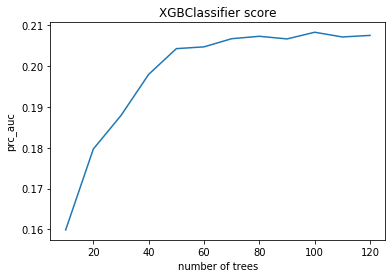

In [266]:
plt.plot(number_of_estimators, scores_estimators)
plt.xlabel('number of trees')
plt.ylabel('prc_auc')
plt.title('XGBClassifier score')

In [269]:
depths = np.arange(1, 12, 1)
scores_depth = []
for n in depths:
    print (n),
    clf_xgb = XGBClassifier(max_depth = n, class_weight = 'balanced', random_state=2)
    scores_depth.append(cross_val_score(clf_xgb, X_train_prep, y_train, scoring = 'average_precision', cv = skf).mean())

1
2
3
4
5
6
7
8
9
10
11


Text(0.5, 1.0, 'XGBClassifier score')

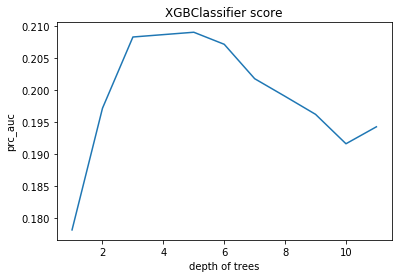

In [270]:
plt.plot(depths, scores_depth)
plt.xlabel('depth of trees')
plt.ylabel('prc_auc')
plt.title('XGBClassifier score')

In [274]:
etas = np.arange(0.01, 0.11, 0.01)
scores_etas = []
for n in etas:
    print (n),
    clf_xgb = XGBClassifier(learning_rate=n, class_weight = 'balanced', random_state=2)
    scores_etas.append(cross_val_score(clf_xgb, X_train_prep, y_train, scoring = 'average_precision', cv = skf).mean())

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999


Text(0.5, 1.0, 'XGBClassifier score')

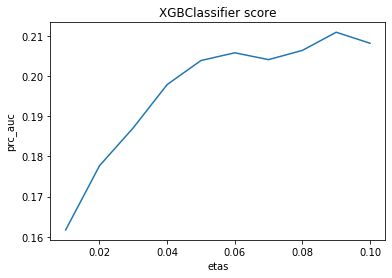

In [275]:
plt.plot(etas, scores_etas)
plt.xlabel('etas')
plt.ylabel('prc_auc')
plt.title('XGBClassifier score')

In [280]:
clf_xgb = XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.09, class_weight = 'balanced', random_state=2)

In [281]:
clf_xgb.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity', 'class_weight'])

In [282]:
parameters_grid_xgb ={
'n_estimators':[100],
'max_depth' : [3,4,5],
'learning_rate': [0.06, 0.08, 0.09]   
}

In [283]:
grid_cv_xgb = GridSearchCV(clf_xgb, parameters_grid_xgb, refit='prc_auc', scoring = scoring, cv = skf)

#### Оптимальные параметры классификатора:

In [284]:
%%time
grid_cv_xgb.fit(X_train_prep, y_train)

Wall time: 11min 51s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.09, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n...
                                     random_state=2, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.06, 0.08, 0.09],
                         'max_depth': [3, 4, 5], 'n_esti

In [285]:
print (grid_cv_xgb.best_score_)
print (grid_cv_xgb.best_params_)
print (grid_cv_xgb.best_index_)

0.21307654616493862
{'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100}
4


In [286]:
print ("mean_test_prc_auc:", grid_cv_xgb.cv_results_['mean_test_prc_auc'])
print ("mean_test_roc_auc:", grid_cv_xgb.cv_results_['mean_test_roc_auc'])

mean_test_prc_auc: [0.20585889 0.20979152 0.21156623 0.20645281 0.21307655 0.21020836
 0.2109816  0.21133553 0.21023477]
mean_test_roc_auc: [0.73564602 0.73467464 0.73491705 0.73720522 0.73507916 0.73487453
 0.73744003 0.73624184 0.73481049]


#### Подбор параметров как препроцессинга, так и самого классификатора не сильно улучшил качество модели, prc_auc увеличилась, однако менее значимая roc_auc уменьшилась.

### Важность признаков

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Для обработки категориальных признаков использовался BinaryEncoder, что означает, 
сначала категории преобразовываются в числа, как, например, в OrdinalEncoder, а затем числа преобразовываются в бинарный код, 
который по частям распределяется по колонкам.
Поэтому нельзя по feature_importances_ классификатора сказать какой из **категориальных** призаков является важным. 

Можно только определить важность **числовых** переменных: 

Сначала определим какие признаки остались после feature_selection:

In [300]:
output = cross_validate(clf_xgb, X_train, y_train, cv=skf, scoring = scoring, return_estimator =True)

In [474]:
features_selected = pd.DataFrame(columns=['Var'])
features_selected['Var'] = num_cols.columns.values
features_selected['f_selected_fold_1'] = output['estimator'][0]['feature_selection'].get_support()[:174]
features_selected['f_selected_fold_2'] = output['estimator'][1]['feature_selection'].get_support()[:174]
features_selected['f_selected_fold_3'] = output['estimator'][2]['feature_selection'].get_support()[:174]
features_selected['f_selected_fold_4'] = output['estimator'][3]['feature_selection'].get_support()[:174]

In [475]:
features_selected.loc[features_selected['f_selected_fold_1']==True]

,Var,f_selected_fold_1,f_selected_fold_2,f_selected_fold_3,f_selected_fold_4
5,Var6,True,True,True,True
6,Var7,True,True,True,True
11,Var13,True,True,True,True
17,Var21,True,True,True,True
18,Var22,True,True,True,True
20,Var24,True,True,True,True
21,Var25,True,True,True,True
24,Var28,True,True,True,True
29,Var35,True,True,True,True
32,Var38,True,True,True,True


Затем определим, какие признаки после feature_selection оставил сам классификатор в feature_importances_:

In [484]:
selected_features=features_selected.loc[features_selected['f_selected_fold_1']==True].Var.values
selected_features

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var57', 'Var65', 'Var72', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var94',
       'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125',
       'Var126', 'Var132', 'Var133', 'Var134', 'Var140', 'Var144',
       'Var149', 'Var153', 'Var160', 'Var163', 'Var181', 'Var189'],
      dtype=object)

In [485]:
clf_feature_imp = pd.DataFrame(index=[selected_features])
clf_feature_imp['clf_importance_fold_1'] = output['estimator'][0]['classifier'].feature_importances_[:39]
clf_feature_imp['clf_importance_fold_2'] = output['estimator'][1]['classifier'].feature_importances_[:39]
clf_feature_imp['clf_importance_fold_3'] = output['estimator'][2]['classifier'].feature_importances_[:39]
clf_feature_imp['clf_importance_fold_4'] = output['estimator'][3]['classifier'].feature_importances_[:39]
clf_feature_imp['clf_importance_mean'] = clf_feature_imp.mean(axis=1)

In [492]:
features_selected.shape

(174, 5)

In [490]:
clf_feature_imp.shape

(39, 5)

#### С одной стороны, по предыдущим вычислениям на 1-ой неделе, разреженность лишь 42 из 190 числовых переменных ниже 90%. С другой стороны, в данный момент, из 174 числовых переменных модель в feature_selection оставила только 39, что говорит о том, что она могла удалить разреженные переменные, пропуски которых заменены на среднюю, и в результате имеющие низкую дисперсию.

#### Наиболее важные числовые признаки в модели:

In [487]:
clf_feature_imp.sort_values(['clf_importance_mean'], ascending=False).head(10)

,clf_importance_fold_1,clf_importance_fold_2,clf_importance_fold_3,clf_importance_fold_4,clf_importance_mean
Var132,0.005622,0.032559,0.024781,0.026239,0.022300
Var76,0.007051,0.019989,0.024316,0.022401,0.018439
Var74,0.017054,0.013696,0.012795,0.012106,0.013913
Var126,0.029698,0.006979,0.005187,0.006506,0.012093
Var144,0.007967,0.009679,0.010077,0.013664,0.010347
Var119,0.006716,0.010328,0.009653,0.009735,0.009108
Var6,0.009623,0.008672,0.008626,0.008758,0.008920
Var73,0.016461,0.006676,0.004762,0.007580,0.008870
Var140,0.012397,0.007819,0.007196,0.007535,0.008737
Var22,0.010794,0.008143,0.007613,0.007392,0.008485


#### Наименее важные числовые признаки в модели:

In [488]:
clf_feature_imp.sort_values(['clf_importance_mean'], ascending=False).tail(10)

,clf_importance_fold_1,clf_importance_fold_2,clf_importance_fold_3,clf_importance_fold_4,clf_importance_mean
Var28,0.006901,0.006453,0.005830,0.006154,0.006335
Var160,0.005403,0.007449,0.005994,0.006336,0.006295
Var189,0.012323,0.000391,0.007937,0.002869,0.005880
Var109,0.004680,0.006354,0.004948,0.007233,0.005804
Var57,0.006338,0.007936,0.002170,0.005425,0.005467
Var133,0.007456,0.004473,0.004710,0.004945,0.005396
Var65,0.005263,0.005096,0.004446,0.005214,0.005005
Var94,0.005292,0.003642,0.005851,0.004045,0.004707
Var24,0.002527,0.006516,0.003379,0.004377,0.004200
Var35,0.001545,0.003788,0.000466,0.004531,0.002583


#### По результатам feature_importances_ одна из двух ниже рассмотренных  числовых переменных оказалась наиболее важной, а другая - наоборот, в добавок по наблюдениям на первой неделе, в попарных координатах числовых переменных, интересно было посмотреть на их связь:
* Var57-Var126: объекты занимали определенную прямоугольную область.
* Var35-Var132: значения собираются выше или ниже линии под углом.
* Var133-Var76: значения собираются выше или ниже диагонали на графике.

### Анализ объектов, на которых достигается наибольшая ошибка классификации.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [14]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', NeighbourhoodCleaningRule(random_state=2)),
                          ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 10, random_state=2))),
                          ('classifier', XGBClassifier(n_estimators = 100, max_depth = 4, learning_rate = 0.08, class_weight = 'balanced', random_state=2))]) 

Зададим в GridSearchCV какой-нибудь один параметр (т.е. не для подбора) для дальнейшего рассмотрения графиков precision и recall на фолдах кросс-валидации:

In [15]:
parameters_grid_xgb ={'classifier__n_estimators':[100]}

In [16]:
grid_cv_xgb = GridSearchCV(clf_xgb, parameters_grid_xgb, refit='prc_auc', scoring = scoring, cv = skf, n_jobs=-1)

In [17]:
%%time
grid_cv_xgb.fit(X_train, y_train)

Wall time: 34min 31s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [19]:
print (grid_cv_xgb.best_score_)
print (grid_cv_xgb.best_params_)
print (grid_cv_xgb.best_index_)

0.21104446357964673
{'classifier__n_estimators': 100}
0


In [20]:
print ("mean_test_prc_auc:", grid_cv_xgb.cv_results_['mean_test_prc_auc'])
print ("mean_test_roc_auc:", grid_cv_xgb.cv_results_['mean_test_roc_auc'])

mean_test_prc_auc: [0.21104446]
mean_test_roc_auc: [0.73387157]


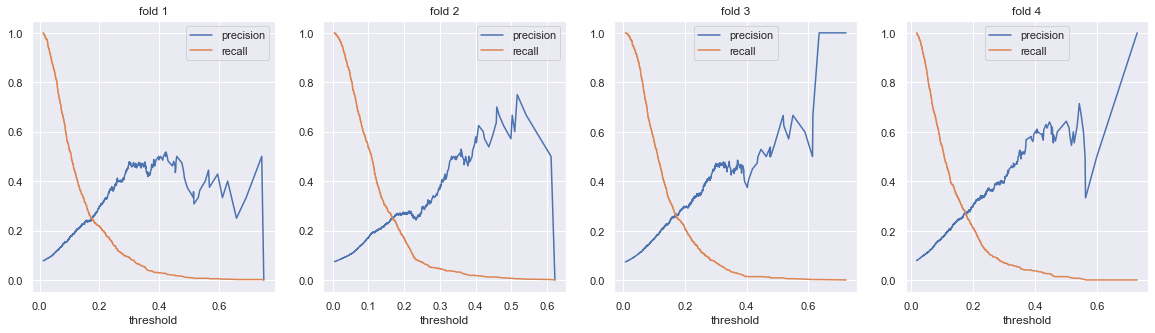

In [550]:
precs = []
recs = []
threshs = []
labels = ["fold 1", "fold 2", "fold 3", "fold 4"]

for train, test in skf.split(X_train, y_train):
    probas_ = grid_cv_xgb.best_estimator_.fit(X_train.iloc[train], y_train[train]).predict_proba(X_train.iloc[test])
    prec, rec, thresh = precision_recall_curve(y_train[test], probas_[:, 1])
    precs.append(prec)
    recs.append(rec)
    threshs.append(thresh)

plt.figure(figsize=(20, 5))
for i in range(4):
    ax = plt.subplot(1, 4, i+1)
    plt.plot(threshs[i], precs[i][:-1], label="precision")
    plt.plot(threshs[i], recs[i][:-1], label="recall")
    plt.xlabel("threshold")
    ax.set_title(labels[i])
    plt.legend()

Как видно, кривая recall, в отличие от кривой precision на всех фолдах, очень резкая, поэтому при подобранной максимальной prc_auc, придется подобрать порог бинаризации ниже стандортного 0.5.

Создадим датафрейм для просмотра и сортировки видов ошибок:

In [ ]:
control_data = pd.DataFrame(X_control.index.values, columns=['ID']) 
control_data['predict_proba']=grid_cv_xgb.best_estimator_.predict_proba(X_control)[:, 1]

Теперь выберем порог бинаризации, увеличивающий recall, к примеру 0.1:

In [25]:
T = 0.1 
control_data['predict_label']=np.where(control_data['predict_proba']>T, 1, -1)
control_data['label']=y_control
control_data['clf_errors'] = np.where((control_data['predict_label']==-1) & (control_data['label']==1), 'recall_mistake',
                                     np.where((control_data['predict_label']==1) & (control_data['label']==-1), 'precision_mistake', 'no_mistake'))

In [26]:
control_data

,ID,predict_proba,predict_label,label,clf_errors
0,37920,0.029705,-1,-1,no_mistake
1,8524,0.052931,-1,-1,no_mistake
2,34511,0.047413,-1,-1,no_mistake
3,5060,0.039812,-1,-1,no_mistake
4,34549,0.112204,1,-1,precision_mistake
5,32968,0.553618,1,1,no_mistake
6,9111,0.039031,-1,-1,no_mistake
7,39665,0.091271,-1,-1,no_mistake
8,15221,0.065400,-1,-1,no_mistake
9,3316,0.158519,1,1,no_mistake


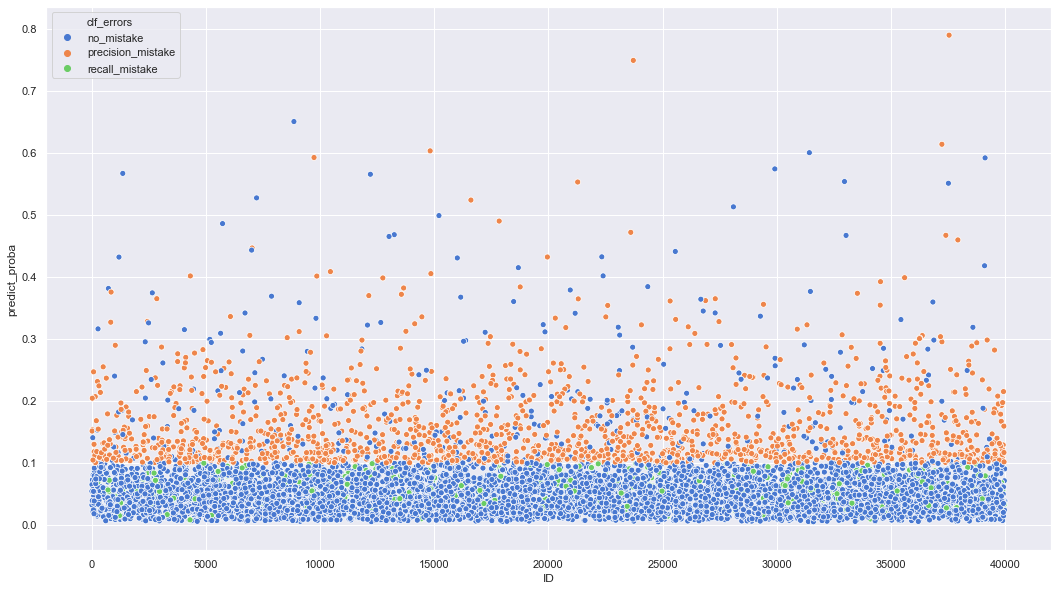

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18, 10)})
control_data_sns = control_data.drop(['predict_label', 'label'], 1, inplace=False)
ax = sns.scatterplot(x="ID", y="predict_proba", hue="clf_errors", data=control_data_sns, palette="muted")

Как видно из графика, ошибки recall могут находиться намного ниже порога, и подбор порога намного ниже 0.1 будет сильно увеличивать ошибки precision.

In [42]:
pd.crosstab(control_data['predict_label'],y_control,  rownames=['Predicted'], colnames=['True'], margins=True)

True,-1,1,All
Predicted,,,
-1,5860,280,6140
1,1545,315,1860
All,7405,595,8000


In [134]:
print (classification_report(y_control, control_data['predict_label']))

              precision    recall  f1-score   support

          -1       0.95      0.79      0.87      7405
           1       0.17      0.53      0.26       595

    accuracy                           0.77      8000
   macro avg       0.56      0.66      0.56      8000
weighted avg       0.90      0.77      0.82      8000



#### Приоритетной ошибкой для рассмотрения является recall, поэтому будем понимать "наибольшую" ошибку как отнесение объекта с чужому классу с наименьшей вероятностью (к примеру, ниже 2%):

In [113]:
top_recall_errors=control_data.loc[(control_data['predict_proba'] < 0.02) & (control_data['clf_errors'] == 'recall_mistake')].sort_values(['predict_proba'], ascending=True)
top_recall_errors

,ID,predict_proba,predict_label,label,clf_errors
4151,29190,0.007676,-1,1,recall_mistake
7607,4309,0.008151,-1,1,recall_mistake
192,34104,0.009481,-1,1,recall_mistake
2019,14435,0.009850,-1,1,recall_mistake
4587,25211,0.013633,-1,1,recall_mistake
6459,1217,0.014924,-1,1,recall_mistake
7171,5251,0.015154,-1,1,recall_mistake
5342,29403,0.016264,-1,1,recall_mistake
4491,3308,0.016590,-1,1,recall_mistake
1476,16471,0.019309,-1,1,recall_mistake


#### Для просмотра объектов, на которых достигается данный вид ошибок, выберем наиболее важные признаки по модели:

#### объекты по числовым признакам:

In [132]:
X_control.loc[:, selected_features[:20]].describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85
count,7136.000000,7142.000000,7142.000000,7136.000000,7229.000000,6862.000000,7229.000000,7228.000000,7229.000000,7.229000e+03,8000.000000,7142.000000,4433.000000,8000.000000,7142.000000,7.229000e+03,7229.000000,7.136000e+03,7229.000000,7229.000000
mean,1317.281110,6.869644,1223.681882,235.935538,291.351501,4.635966,97.850325,223.514975,0.711025,2.584177e+06,3.527534,14.930272,4.248590,67.057000,98.155839,1.493305e+06,0.483884,1.050872e+05,19.834694,8.529534
std,2431.225897,6.430607,2409.869962,503.137053,625.679343,9.924953,191.120687,93.674761,2.875034,3.041983e+06,2.029731,10.069561,2.367902,53.618319,277.334170,1.847947e+06,1.965297,1.140828e+05,70.583805,19.528238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000214,9.000000,3.000000,4.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,518.000000,0.000000,0.000000,112.000000,135.000000,0.000000,16.000000,166.560000,0.000000,6.858000e+03,1.759720,9.000000,3.000000,24.000000,0.000000,9.087200e+04,0.000000,1.647656e+04,0.000000,0.000000
50%,854.000000,7.000000,228.000000,144.000000,180.000000,2.000000,48.000000,220.080000,0.000000,1.216116e+06,3.519867,9.000000,3.000000,52.000000,7.000000,8.984960e+05,0.000000,7.295535e+04,10.000000,4.000000
75%,1442.000000,7.000000,1623.000000,232.000000,285.000000,6.000000,120.000000,264.440000,0.000000,4.574232e+06,5.305704,18.000000,6.000000,104.000000,91.000000,2.314936e+06,0.000000,1.838881e+05,25.000000,10.000000
max,82264.000000,35.000000,51536.000000,20652.000000,25815.000000,448.000000,5864.000000,2434.240000,35.000000,1.814400e+07,6.999359,126.000000,18.000000,260.000000,13783.000000,1.935360e+07,27.000000,1.700883e+06,2535.000000,932.000000


In [136]:
X_control.loc[top_recall_errors['ID'].values, selected_features[:20]] #.describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85
29190,1253.0,21.0,1600.0,312.0,390.0,20.0,168.0,166.56,0.0,0.0,6.319590,27.0,9.0,104,301.0,315496.0,0.0,24575.82,0.0,22.0
4309,1246.0,7.0,4712.0,180.0,225.0,4.0,128.0,176.56,0.0,3762.0,2.390088,9.0,NaN,164,175.0,1531200.0,0.0,20317.98,0.0,10.0
34104,1750.0,7.0,504.0,220.0,275.0,2.0,56.0,233.52,0.0,5033550.0,4.575091,9.0,3.0,76,182.0,1148304.0,0.0,17441.97,25.0,4.0
14435,539.0,7.0,56.0,32.0,40.0,0.0,8.0,253.52,0.0,0.0,0.378338,18.0,6.0,30,28.0,207176.0,0.0,193504.80,0.0,2.0
25211,2219.0,14.0,336.0,320.0,400.0,0.0,112.0,98.08,30.0,5183412.0,5.615253,18.0,6.0,64,7.0,1000688.0,3.0,42798.90,30.0,6.0
1217,896.0,7.0,2544.0,140.0,175.0,0.0,72.0,305.28,0.0,3303702.0,6.196539,9.0,3.0,80,70.0,3778584.0,0.0,184092.90,15.0,2.0
5251,2107.0,0.0,164.0,8.0,10.0,0.0,0.0,220.08,10.0,0.0,6.889554,9.0,NaN,48,0.0,0.0,0.0,18510.75,0.0,0.0
29403,3276.0,21.0,168.0,664.0,830.0,12.0,232.0,166.56,0.0,0.0,2.453108,63.0,12.0,106,98.0,844424.0,0.0,6625.32,0.0,22.0
3308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.692801,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
16471,770.0,0.0,0.0,64.0,80.0,4.0,8.0,264.72,0.0,8450580.0,1.474899,9.0,3.0,18,0.0,638056.0,0.0,55355.70,10.0,4.0


#### По данным объектам на числовых признаках тяжело что-либо предположить, можно сравнивать средние и 75% персентили, к примеру.

#### объекты по категориальным признакам:

In [129]:
X_control.loc[:, cat_cols.columns.values[:]].describe()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var218,Var219,Var221,Var223,Var224,Var225,Var226,Var227,Var228,Var229
count,137,7942,8000,1997,8000,8000,7973,8000,8000,3925,...,7882,7143,8000,7143,130,3818,8000,8000,8000,3442
unique,1,287,38,3,16,4,182,1848,1549,3548,...,2,18,7,4,1,3,23,7,27,4
top,r__I,oUPBcmzkzH,RO12,SEuy,taul,1K8T,0Xwj,fhk21Ss,r83_sZi,Uw6SDm8,...,cJvF,FzaX,oslk,LM8l689qOp,4n2X,ELof,FSa2,RAYp,F2FyR07IdsN7I,am7c
freq,137,67,5727,1960,7671,7926,745,736,144,10,...,4073,6448,5883,5876,130,1821,1304,5555,5190,1872


In [128]:
X_control.loc[top_recall_errors['ID'].values, cat_cols.columns.values[:]] #.describe()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var218,Var219,Var221,Var223,Var224,Var225,Var226,Var227,Var228,Var229
29190,NaN,gE8Wq6edh4,RO12,NaN,taul,1K8T,PGNs,iJzviRg,3cO76t0,nFLuZLx,...,UYBR,OFWH,zCkv,LM8l689qOp,NaN,ELof,453m,ZI9m,R4y5gQQWY8OodqDV,am7c
4309,NaN,8I1r4RXXnK,2Knk1KF,NaN,taul,1K8T,uErj,fhk21Ss,n1zVHpT8NN,yP01_Zt,...,cJvF,FzaX,zCkv,LM8l689qOp,NaN,ELof,Xa3G,ZI9m,TCU50_Yjmm6GIBZ0lL_,am7c
34104,NaN,kMJt0GoOh3,RO12,SEuy,taul,1K8T,487l,1nw8HPr,Cy0RhGn,bXJihTs,...,UYBR,FzaX,oslk,LM8l689qOp,NaN,kG3k,Qu4f,RAYp,F2FyR07IdsN7I,am7c
14435,NaN,DHevyx7IEC,RO12,NaN,taul,1K8T,hM6W,rRoCfXI,KyxX4chnKM,NaN,...,UYBR,OFWH,oslk,LM8l689qOp,NaN,NaN,szEZ,RAYp,F2FyR07IdsN7I,NaN
25211,NaN,xOXr4RXktW,RO12,NaN,taul,1K8T,0Y9G,gmq88LT,76MiCML,6Lq_UvT,...,cJvF,FzaX,oslk,LM8l689qOp,NaN,ELof,7FJQ,RAYp,F2FyR07IdsN7I,NaN
1217,NaN,9hRmfo875g,RO12,NaN,taul,1K8T,lK27,gRinF0C,Z8ZAV8jDl3,NaN,...,cJvF,FzaX,oslk,LM8l689qOp,NaN,NaN,wX53,RAYp,F2FyR07IdsN7I,mj86
5251,NaN,zcROj1KVEH,RO12,NaN,taul,1K8T,xgSF,lCphli9,_jTP8ioIlJ,R40FpO4,...,cJvF,OFWH,oslk,LM8l689qOp,NaN,ELof,kwS7,RAYp,F2FyR07IdsN7I,mj86
29403,NaN,DQlrEyXXnK,RO12,SEuy,taul,1K8T,z32l,I0Kp6vu,LJF4fPp,tTUdZA9,...,cJvF,FzaX,oslk,LM8l689qOp,NaN,xG3x,Aoh3,RAYp,F2FyR07IdsN7I,am7c
3308,NaN,vAsTmBfHUn,RO12,NaN,taul,1K8T,TyGl,65yJUS7,BZ1DVSQNvCeg4,NaN,...,UYBR,NaN,oslk,NaN,4n2X,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN
16471,NaN,DQlrEyXXnK,RO12,NaN,taul,1K8T,TyGl,LG0JHBC,JSmlJZ_,NaN,...,UYBR,FzaX,oslk,LM8l689qOp,NaN,NaN,Aoh3,RAYp,F2FyR07IdsN7I,NaN


#### Можно предположить, что наибольшая ошибка recall достигается на этих объектах из-за наличия пустых ячеек в следующих категориальных переменных:   
Var191, Var194, Var201, Var203, Var213, Var215, Var224

### Финальное решение

9\. По итогам проведенных экспериментов постройте финальное решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Обработка числовых переменных:

In [ ]:
numeric_features = num_cols.columns.values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # замена пропущенных значений на среднее.
    ('scaler', StandardScaler())]) # мастабирование в пайплайне

Обработка категориальных переменных:

In [ ]:
categorical_features = cat_cols.columns.values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')), # вместо пропуска добавится еще одна категория 'NA' 
    ('encoder', BinaryEncoder())]) # получится 214 колонок

Трансформер для пайплайна внутри каждого типа перменных и дальнейшего объединения:

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Итоговый пайплайн:

In [ ]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('undersampling', NeighbourhoodCleaningRule(random_state=2)),
                          ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 10, random_state=2))),
                          ('classifier', XGBClassifier(n_estimators = 100, max_depth = 4, learning_rate = 0.08, class_weight = 'balanced', random_state=2))]) 

In [290]:
clf_pipe_results('xgboost_final', clf_xgb, X_train, y_train)

,prc_auc,roc_auc
xgboost_final,0.211045,0.733872


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

#### Для улучшения модели можно:
1. подобрать все параметры (в parameters_grid_xgb), как препроцессинга, так и самого классификатора на GridSearchCV, хоть это и займет очень много времени, при этом использовать больше вариантов undersampling-а, обработки категориальных признаков, моделей для отбора признаков; 
2. попробовать подбирать разные пороги отбора признаков в параметрах функций feature_selection_.
3. изначально удалить все признаки, пропуски на которых составляют >75%, к примеру.
3. использовать методы понижения размерности: PCA, MDS, t-SNE, а затем классификатор knn при меньших количествах объектов.